# Machines Manufacturing Capital Budgeting Model

#### The Problem
<p>You work for a new startup that is trying to manufacture phones. You are tasked with building a model which will
help determine how many machines to invest in and how much to spend on marketing.</p> 

<p>Each machine produces n output phones per year. Each phone sells for p phone and costs c phone in variable costs to produce. After n life years, the machine can no longer produce output, but may be scrapped for p scrap.</p> 

<p>The machine will not be replaced, so you may end up with zero total output before your model time period ends. Equity investment is limited, so in each year you can spend cmachine to either buy a machine or buy advertisements. In the first year you must buy a machine.</p>

<p>Any other machine purchases must be made one after another (advertising can only begin after machine buying is done). 
Demand for your phones starts at d1. Each time you advertise, demand increases by gd%. The prevailing market interest rate is r.</p>

#### Notes
- You may limit your model to 20 years and a maximum of 5 machines if it is helpful.
- For simplicity, assume that cmachine is paid in every year, even after all machines have shut down.
- Ensure that you can change the inputs and the outputs change as expected.
- For simplicity, assume that fractional phones can be sold, you do not need to round the quantity transacted.

[**Setup**](#Setup): Runs any imports and other setup<br>
[**Inputs**](#Inputs): Defines the inputs for the model

#### Bonus Problem
<p>It is unrealistic to assume that price and demand are unrelated. To extend the model, we can introduce a relationship between price and demand,
 given by the following equation:</p>

$d_{1}$ = $d_{c}$ − $E_{phone}$ <br>
$E_{phone}$: Price elasticity of demand <br>
$d_{c}$: Demand constant

<p>For elasticities and constants [(E = 500, d c = 900000), (E = 200, d c = 500000), (E = 100, d c = 300000)] (3 total cases), 
 and taking the other model inputs in the Check your Work section, determine the optimal price for each elasticity, that is the price which maximizes the NPV.</p>

#### Notes
- $d_{1}$ is no longer an input, but an output.
- This bonus requires optimization. (In Python, the scipy package provides optimization tools.)

MODEL MADE BY [Thiago Guarino](https://github.com/thiagoguarino)

### SETUP

Setup for the later calculations are here. The necessary packages are imported.

In [16]:
from dataclasses import dataclass
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy_financial as npf

### INPUTS

All of the inputs for the model are defined here. A class is constructed to manage the data, and an instance of the class containing the default inputs is created.

In [17]:
@dataclass
class ModelInputs:
    n_phones: float = 100000
    price_scrap: float = 50000
    price_phone: float = 500
    cost_machine_adv: float = 1000000
    cogs_phone: float = 250
    n_life: int = 10
    n_machines: int = 5
    d_1: float = 100000
    g_d: float = 0.2
    max_year: float = 20
    interest: float = 0.05
        
model_data = ModelInputs()
model_data


ModelInputs(n_phones=100000, price_scrap=50000, price_phone=500, cost_machine_adv=1000000, cogs_phone=250, n_life=10, n_machines=5, d_1=100000, g_d=0.2, max_year=20, interest=0.05)

### MODEL

In [18]:
class Phone_Manufacturing:

    def __init__(self, input: ModelInputs):
        self.input = input
    
    def get_product_demand(self):
        demands = []
        for d in range(1,(self.input.max_year + 1)):   
            if d <= (self.input.n_machines):
                demand = (self.input.d_1)
                demands.append(demand)
            else:
                demand = (self.input.d_1) * (1 + self.input.g_d) ** (d - (self.input.n_machines))
                demands.append(demand)
        return demands
    
    def get_produced_products(self):
        produced_quant = []
        for a in range(1,(self.input.max_year + 1)):
            if a * self.input.n_phones <= (self.input.n_machines * self.input.n_phones):
                prod = self.input.n_phones * a
                produced_quant.append(prod)

            elif a <= self.input.n_life:
                prod = self.input.n_machines * self.input.n_phones
                produced_quant.append(prod)

            elif a <= (self.input.n_machines + self.input.n_life):
                prod = (self.input.n_machines * self.input.n_phones) - (self.input.n_phones) * (a - self.input.n_life)
                produced_quant.append(prod)

            elif a > (self.input.n_life + self.input.n_machines):
                prod = 0
                produced_quant.append(prod)
        return produced_quant

    def get_sales_revenue(self, demands, produced_quant):
        revenues = []
        for r in range(1,(self.input.max_year + 1)):
            if demands[r-1] <= produced_quant[r-1]:
                revenue = round(self.input.price_phone * demands[r-1])
                revenues.append(revenue)
            else:
                revenue = round(self.input.price_phone * produced_quant[r-1])
                revenues.append(revenue)
        return revenues

    def get_cost_sales(self, demands, produced_quant):
        cost_sales = []
        for s in range(1,(self.input.max_year + 1)):
            if demands[s-1] <= produced_quant[s-1]:
                cost = round(self.input.cogs_phone * demands[s-1])
                cost_sales.append(cost)
            else:
                cost = round(self.input.cogs_phone * produced_quant[s-1])
                cost_sales.append(cost)
        return cost_sales

    def get_profits(self, revenues, cost_sales):
        profits = []
        for p in range(1,(self.input.max_year + 1)):
            profit = revenues[p-1] - cost_sales[p-1]
            profits.append(profit)
        return profits
    
    def get_cash_flows_from_profits(self, profits, initial_investment=0):
        '''
        returns a list containing the cash flows
        '''

        cash_flows = [initial_investment]

        for c in range(1,(self.input.max_year+1)):
            if (c > self.input.n_life) and (c <= (self.input.n_life + self.input.n_machines)):
                c_flow = profits[c-1] - (self.input.cost_machine_adv) + (self.input.price_scrap)
                cash_flows.append(c_flow)
            else:
                c_flow = (profits[c-1] - (self.input.cost_machine_adv))
                cash_flows.append(c_flow)
        return cash_flows

    def get_cash_flows(self):
        demands = self.get_product_demand()
        product_products = self.get_produced_products()
        revenues = self.get_sales_revenue(demands, product_products)
        cost_sales = self.get_cost_sales(demands, product_products)
        profits = self.get_profits(revenues, cost_sales)
        return self.get_cash_flows_from_profits(profits, initial_investment=0)


In [19]:
cash_flow_model = Phone_Manufacturing(model_data)
cash_flows = cash_flow_model.get_cash_flows()

print('Cash Flows: ')
for n, cf in enumerate(cash_flows[1:]):
    print(f'Year {n + 1}: {cf:,}')

#net present value function
npv_c = npf.npv(model_data.interest, cash_flows)
print(f'NPV: {npv_c:,.2f}')

Cash Flows: 
Year 1: 24,000,000
Year 2: 24,000,000
Year 3: 24,000,000
Year 4: 24,000,000
Year 5: 24,000,000
Year 6: 29,000,000
Year 7: 35,000,000
Year 8: 42,200,000
Year 9: 50,840,000
Year 10: 61,208,000
Year 11: 73,699,600
Year 12: 74,050,000
Year 13: 49,050,000
Year 14: 24,050,000
Year 15: -950,000
Year 16: -1,000,000
Year 17: -1,000,000
Year 18: -1,000,000
Year 19: -1,000,000
Year 20: -1,000,000
NPV: 369,276,542.47


## OUTPUT DATAFRAME
  - See how the NPV changes when the number of machines and initial demand change
  - Output a styled DataFrame 

In [20]:
def outputs_to_df(model):
    cash_flow_model = Phone_Manufacturing(model)
    cash_flows = cash_flow_model.get_cash_flows()
    npv_list = list()
    cf_list = list()

    for cash_flow in cash_flows:
        cf_list.append(cash_flow)
        if len(cf_list) > 1:
            npv_c = npf.npv(model.interest, cf_list)
            npv_list.append(npv_c)
        

    df = pd.DataFrame({
        'year': [year for year in range(1, model.max_year+1)],
        'cash flow': cash_flows[1:],
        'cumulative NPV': npv_list
    })

    return df


## Display the Data Frame

In [21]:
df = outputs_to_df(model_data)


df_display = df.style.format({
    'cash flow': "$ {:,.2f}",
    'cumulative NPV': "$ {:,.2f}"
})

df_display

,year,cash flow,cumulative NPV
0,1,"$ 24,000,000.00","$ 22,857,142.86"
1,2,"$ 24,000,000.00","$ 44,625,850.34"
2,3,"$ 24,000,000.00","$ 65,357,952.70"
3,4,"$ 24,000,000.00","$ 85,102,812.10"
4,5,"$ 24,000,000.00","$ 103,907,440.10"
5,6,"$ 29,000,000.00","$ 125,547,686.60"
6,7,"$ 35,000,000.00","$ 150,421,533.15"
7,8,"$ 42,200,000.00","$ 178,984,154.23"
8,9,"$ 50,840,000.00","$ 211,756,071.53"
9,10,"$ 61,208,000.00","$ 249,332,473.95"


## Visualizing the Dataframe

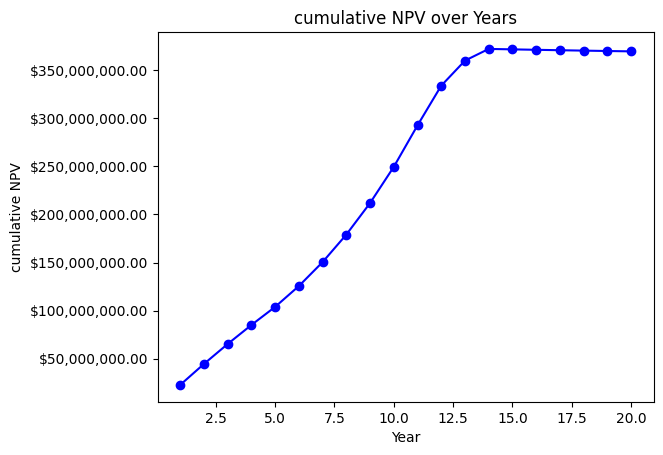

In [22]:
df = outputs_to_df(model_data)

# Call the function to get the DataFrame
df = outputs_to_df(model_data)

# Plot the line graph
plt.plot(df['year'], df['cumulative NPV'], marker='o', linestyle='-', color='blue')

# Set the x-axis and y-axis labels
plt.xlabel('Year')
plt.ylabel('cumulative NPV')

# Set the title of the graph
plt.title('cumulative NPV over Years')

# Format the y-axis tick labels
plt.gca().get_yaxis().set_major_formatter('${:,.2f}'.format)

# Display the line graph
plt.show()


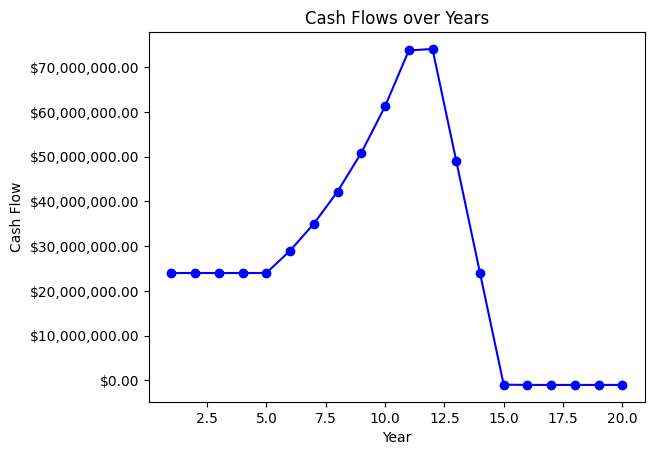

In [23]:
df = outputs_to_df(model_data)

# Call the function to get the DataFrame
df = outputs_to_df(model_data)

# Plot the line graph
plt.plot(df['year'], df['cash flow'], marker='o', linestyle='-', color='blue')

# Set the x-axis and y-axis labels
plt.xlabel('Year')
plt.ylabel('Cash Flow')

# Set the title of the graph
plt.title('Cash Flows over Years')

# Format the y-axis tick labels
plt.gca().get_yaxis().set_major_formatter('${:,.2f}'.format)

# Display the line graph
plt.show()

## Sensitivity Analysis

### 1. setting up the data

In [24]:
def cf_model(data):
    cash_flow_model = Phone_Manufacturing(data)
    cash_flows = cash_flow_model.get_cash_flows()

    #net present value function
    npv_c = npf.npv(model_data.interest, cash_flows)
    return npv_c

def npv_phone_factory_model(model_data, **kwargs):
    altered_model_data = ModelInputs(**kwargs)
    npv_c = cf_model(model_data)
    
    if kwargs:
        npv_c = cf_model(altered_model_data)
        return npv_c
    
    return npv_c

npv_phone_factory_model(model_data=model_data)

369276542.47415346

In [25]:
sa_input_variations = {
  'n_machines': [3, 4, 5, 6, 7],
  'd_1': [
    80000,
    90000,
    100000,
    120000,
    125000,
  ]}

labels = {
  'n_machines': 'N of Machines',
  'd_1': 'Initial Demand'
}



### 2. results for Sensitivity Analysis of the Model

In [26]:
results = []

for n_machines in sa_input_variations['n_machines']:
    for d_1 in sa_input_variations['d_1']:
        # Create the model data object with the current input values
        model_data = ModelInputs(n_machines=n_machines, d_1=d_1)

        # Calculate the output for the current input values
        output = npv_phone_factory_model(model_data)

        # Store the results
        results.append((n_machines, d_1, output))

df = pd.DataFrame(results, columns=['N of Machines', 'Initial Demand', 'Project NPV'])

df_pivot = df.pivot(index='Initial Demand', columns='N of Machines', values='Project NPV')

df_vertical = df_pivot.transpose()

df_style = df_vertical.style.format("$ {:,.2f}").background_gradient(cmap='RdYlGn')

df_style.set_caption("Sensitivity Analysis Results) Project NPV - N of Machines vs. Initial Demand")

df_style



Initial Demand,80000,90000,100000,120000,125000
N of Machines,,,,,
3,"$ 298,989,175.56","$ 329,064,632.22","$ 357,091,838.53","$ 398,986,257.79","$ 407,535,318.23"
4,"$ 303,235,010.20","$ 334,259,254.64","$ 363,332,784.45","$ 416,717,939.32","$ 430,064,228.03"
5,"$ 307,278,662.23","$ 339,206,514.08","$ 369,276,542.47","$ 424,654,694.50","$ 438,499,232.51"
6,"$ 311,129,759.41","$ 343,918,189.74","$ 374,937,264.40","$ 432,213,508.96","$ 446,532,570.10"
7,"$ 314,797,471.00","$ 348,405,499.89","$ 380,328,428.14","$ 439,412,379.87","$ 454,183,367.81"
